In [1]:
from ls_mlkit.my_diffuser import Diffuser, ModelInterface4Diffuser, DiffusionConfig  # type: ignore
from ls_mlkit.my_utils import set_proxy # type: ignore
set_proxy()
# !pip install diffusers
from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline  # type: ignore

model_id = "google/ddpm-celebahq-256"

# load model and scheduler
ddpm = PNDMPipeline.from_pretrained(model_id).to("cuda")  # type: ignore #

# run pipeline in inference (sample random noise and denoise)
image = ddpm()  # type: ignore #

Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/google/ddpm-celebahq-256 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)')))"), '(Request ID: 4719f152-bce9-41f8-b794-86d2f76037ca)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/zengls/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/zengls/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/59 [00:00<?, ?it/s]

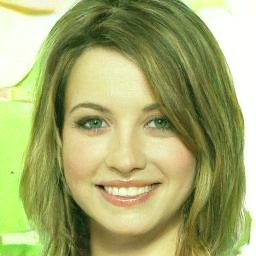

In [ ]:

from IPython.display import display
display(image.images[0])

In [6]:
print(ddpm.__dict__)

{'_internal_dict': FrozenDict({'unet': ('diffusers', 'UNet2DModel'), 'scheduler': ('diffusers', 'PNDMScheduler'), '_name_or_path': 'google/ddpm-celebahq-256'}), 'unet': UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3,